# **Unsupervised Learning**

The tasks in this notebook will be mainly two:


1. Discrimination of Sea ice and lead based on image classification based on Sentinel-2 optical data.

2. Discrimination of Sea ice and lead based on altimetry data classification based on Sentinel-3 altimetry data.




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install rasterio

In [4]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00


# K-means Clustering

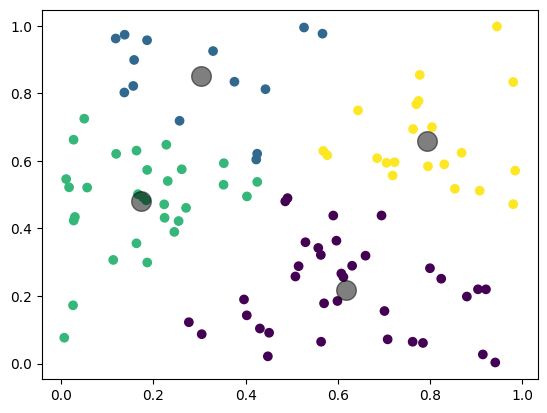

In [5]:
# Python code for K-means clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Sample data
X = np.random.rand(100, 2)

# K-means model
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

# Gaussian Mixture Models (GMM)

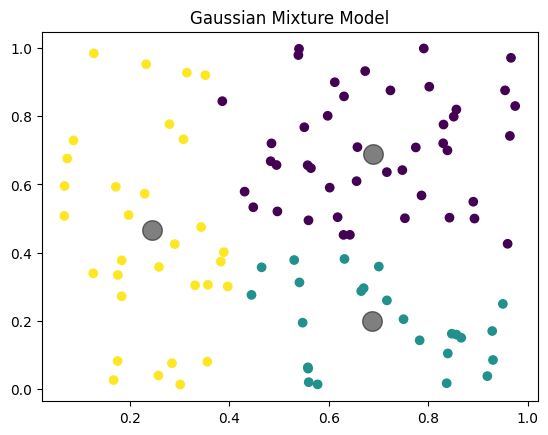

In [6]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Sample data
X = np.random.rand(100, 2)

# GMM model
gmm = GaussianMixture(n_components=3)
gmm.fit(X)
y_gmm = gmm.predict(X)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='viridis')
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Gaussian Mixture Model')
plt.show()


# Image Classification
Now, let's explore the application of these unsupervised methods to image classification tasks, focusing specifically on distinguishing between sea ice and leads in Sentinel-2 imagery.

## K-Means Implementation

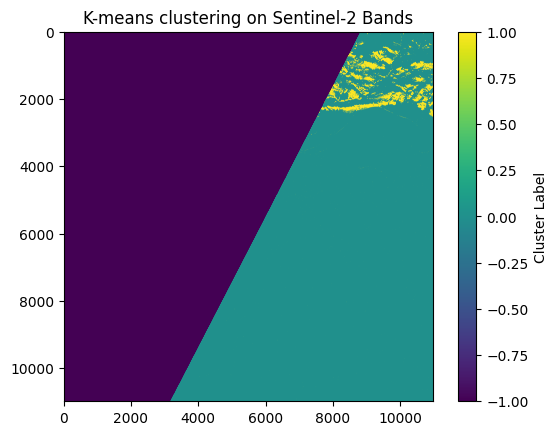

In [7]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/week4/S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/" # You need to specify the path
bands_paths = {
    'B4': base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B3': base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B2': base_path + 'T01WCU_20190301T235611_B02.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for K-means, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 1))

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('K-means clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()

del kmeans, labels, band_data, band_stack, valid_data_mask, X, labels_image

## GMM Implementation

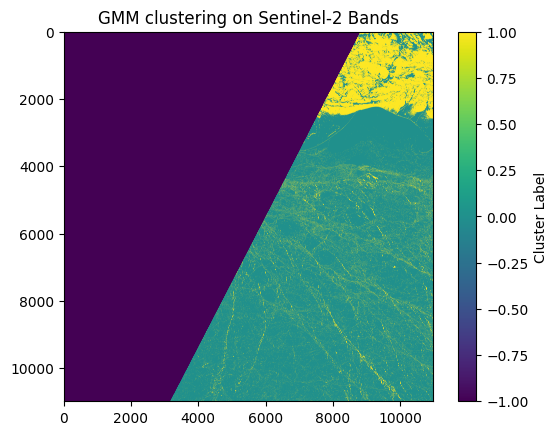

In [8]:
import rasterio
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Paths to the band images
base_path = "/content/drive/MyDrive/week4/S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/" # You need to specify the path
bands_paths = {
    'B4': base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B3': base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B2': base_path + 'T01WCU_20190301T235611_B02.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 1))

# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('GMM clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()

# Read in Functions Needed
Before delving into the modeling process, it's crucial to preprocess the data to ensure compatibility with our analytical models. This involves transforming the raw data into meaningful variables, such as peakniness and stack standard deviation (SSD), etc.

In [9]:
#
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    # from scipy import asarray as ar,exp
    from numpy import asarray as ar, exp

    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD

In [10]:
path = '/content/drive/MyDrive/week4//'
SAR_file = '/S3A_SR_2_LAN_SI_20190307T005808_20190307T012503_20230527T225016_1614_042_131______LN3_R_NT_005.SEN3'
SAR_data = Dataset(path + SAR_file + '/enhanced_measurement.nc')

SAR_lat = unpack_gpod('lat_20_ku')
SAR_lon = unpack_gpod('lon_20_ku')
waves   = unpack_gpod('waveform_20_ku')
sig_0   = unpack_gpod('sig0_water_20_ku')
RIP     = unpack_gpod('rip_20_ku')
flag = unpack_gpod('surf_type_class_20_ku')

# Filter out bad data points using criteria (here, lat >= -99999)
find = np.where(SAR_lat >= -99999)
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
waves   = waves[find]
sig_0   = sig_0[find]
RIP     = RIP[find]

# Calculate additional features
PP = peakiness(waves)
SSD = calculate_SSD(RIP)

# Convert to numpy arrays (if not already)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP)
SSD_np   = np.array(SSD)

# Create data matrix
data = np.column_stack((sig_0_np, PP_np, SSD_np))

# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

Running peakiness function...


/tmp/ipython-input-2237636919.py:63: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


There are some NaN values in the dataset so one way to deal with this is to delete them.

In [11]:
# Remove any rows that contain NaN values
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]

mask = ~np.isnan(data_normalized).any(axis=1)
waves_cleaned = np.array(waves)[mask]
flag_cleaned = np.array(flag)[mask]

data_cleaned = data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]

Number of NaN values in the array: 1283


k-means


In [22]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(data_cleaned)
clusters_kmeans = kmeans.predict(data_cleaned)

In [23]:
unique, counts = np.unique(clusters_kmeans, return_counts=True)
class_counts = dict(zip(unique, counts))
print("K-means Cluster counts:", class_counts)

K-means Cluster counts: {np.int32(0): np.int64(8947), np.int32(1): np.int64(3248)}


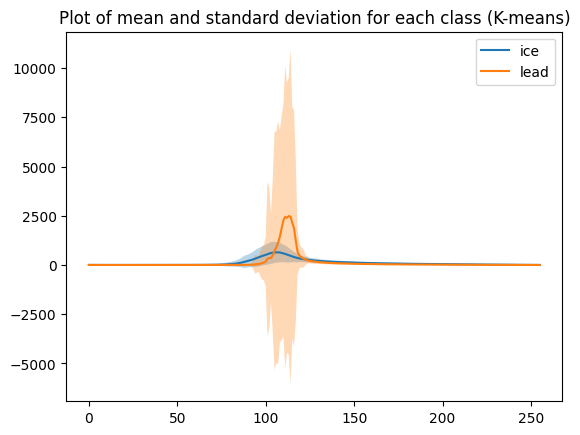

In [24]:
# mean and standard deviation for all echoes (Using K-means clusters)
mean_ice = np.mean(waves_cleaned[clusters_kmeans==0], axis=0)
std_ice = np.std(waves_cleaned[clusters_kmeans==0], axis=0)

plt.plot(mean_ice, label='ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)


mean_lead = np.mean(waves_cleaned[clusters_kmeans==1], axis=0)
std_lead = np.std(waves_cleaned[clusters_kmeans==1], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Plot of mean and standard deviation for each class (K-means)')
plt.legend()
plt.show()

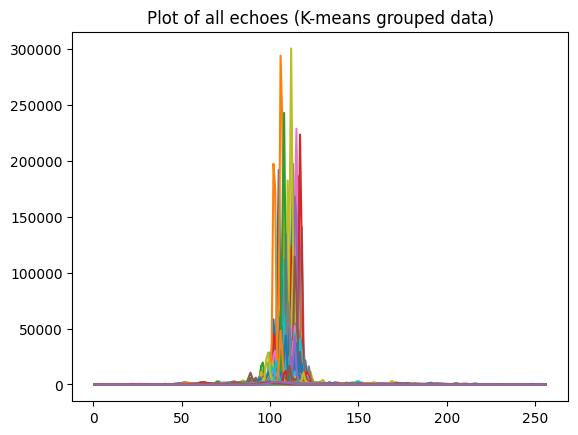

In [36]:
x = np.stack([np.arange(1, waves_cleaned.shape[1] + 1)] * waves_cleaned.shape[0])

plt.plot(x.T, waves_cleaned.T)
plt.title('Plot of all echoes (K-means grouped data)')
plt.show()

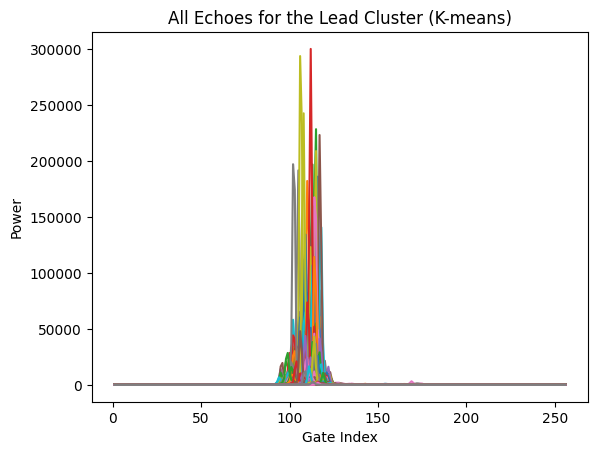

In [26]:
# plot echos for the lead cluster (K-means version)
lead_waves_kmeans = waves_cleaned[clusters_kmeans == 1]

x = np.stack([np.arange(1, lead_waves_kmeans.shape[1] + 1)] * lead_waves_kmeans.shape[0])

plt.plot(x.T, lead_waves_kmeans.T)
plt.title('All Echoes for the Lead Cluster (K-means)')
plt.xlabel('Gate Index')
plt.ylabel('Power')
plt.show()

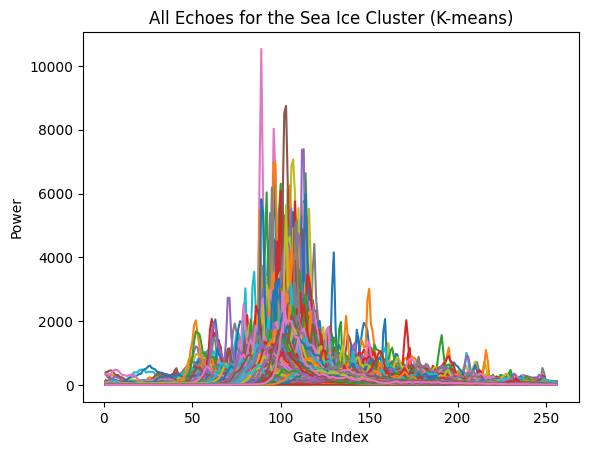

In [27]:
# plot echos for the sea ice cluster (K-means version)
ice_waves_kmeans = waves_cleaned[clusters_kmeans == 0]

x = np.stack([np.arange(1, ice_waves_kmeans.shape[1] + 1)] * ice_waves_kmeans.shape[0])

plt.plot(x.T, ice_waves_kmeans.T)
plt.title('All Echoes for the Sea Ice Cluster (K-means)')
plt.xlabel('Gate Index')
plt.ylabel('Power')
plt.show()

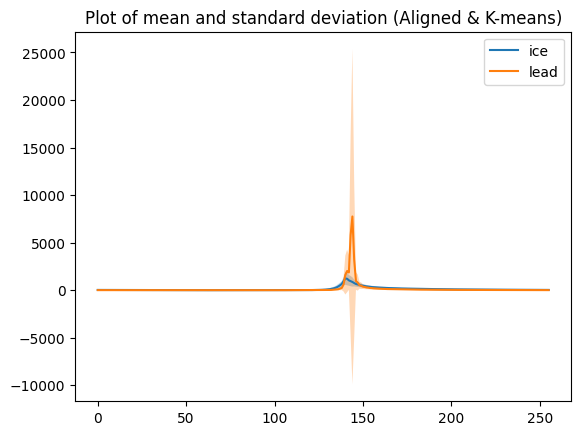

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

reference_wave = waves_cleaned[0]
aligned_waves_all = []

for wave in waves_cleaned:
    correlation = correlate(wave, reference_wave, mode='same')
    shift = np.argmax(correlation) - (len(wave) // 2)
    aligned_waves_all.append(np.roll(wave, -shift))

aligned_waves_all = np.array(aligned_waves_all)

# mean and standard deviation for all echoes (Aligned + K-means)
mean_ice = np.mean(aligned_waves_all[clusters_kmeans == 0], axis=0)
std_ice = np.std(aligned_waves_all[clusters_kmeans == 0], axis=0)

plt.plot(mean_ice, label='ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)

mean_lead = np.mean(aligned_waves_all[clusters_kmeans == 1], axis=0)
std_lead = np.std(aligned_waves_all[clusters_kmeans == 1], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Plot of mean and standard deviation (Aligned & K-means)')
plt.legend()
plt.show()

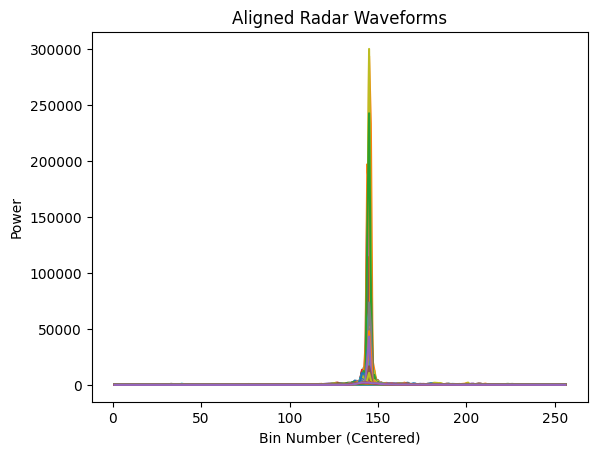

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Define reference and initialize
reference_wave = waves_cleaned[0]
aligned_waves = []

for wave in waves_cleaned:
    # Calculate cross-correlation and timing shift
    correlation = correlate(wave, reference_wave, mode='same')
    shift = np.argmax(correlation) - (len(wave) // 2)

    # Align waveform using circular shift
    aligned_waves.append(np.roll(wave, -shift))

aligned_waves = np.array(aligned_waves)

# Coordinate grid for plotting
x = np.stack([np.arange(1, aligned_waves.shape[1] + 1)] * aligned_waves.shape[0])

plt.plot(x.T, aligned_waves.T)
plt.title('Aligned Radar Waveforms')
plt.xlabel('Bin Number (Centered)')
plt.ylabel('Power')
plt.show()

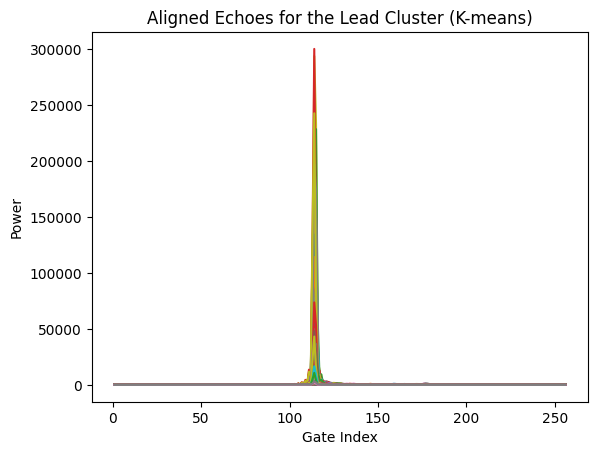

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Filter Lead waveforms (Cluster 1)
lead_waves = waves_cleaned[clusters_kmeans == 1]

# Set reference and initialize
reference_wave = lead_waves[0]
aligned_lead = []

for wave in lead_waves:
    # Calculate correlation and peak shift
    correlation = correlate(wave, reference_wave, mode='same')
    shift = np.argmax(correlation) - (len(wave) // 2)

    # Align waveform using circular shift
    aligned_lead.append(np.roll(wave, -shift))

aligned_lead = np.array(aligned_lead)

# Coordinate grid for plotting
x = np.stack([np.arange(1, aligned_lead.shape[1] + 1)] * aligned_lead.shape[0])

plt.plot(x.T, aligned_lead.T)
plt.title('Aligned Echoes for the Lead Cluster (K-means)')
plt.xlabel('Gate Index')
plt.ylabel('Power')
plt.show()

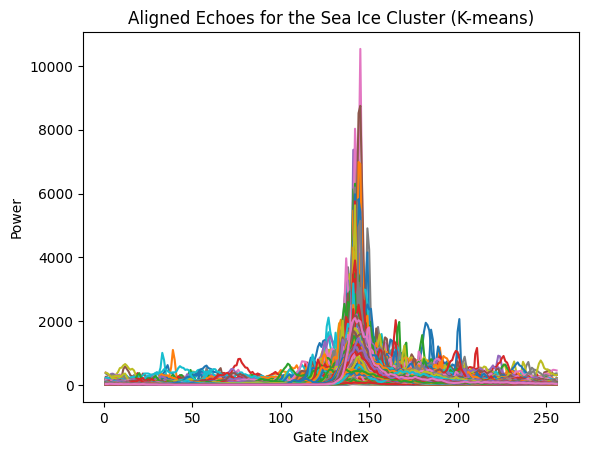

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Filter Sea Ice waveforms (Cluster 0)
ice_waves = waves_cleaned[clusters_kmeans == 0]

# Set reference and initialize
reference_wave = ice_waves[0]
aligned_ice = []

for wave in ice_waves:
    # Calculate correlation and peak shift
    correlation = correlate(wave, reference_wave, mode='same')
    shift = np.argmax(correlation) - (len(wave) // 2)

    # Align waveform using circular shift
    aligned_ice.append(np.roll(wave, -shift))

aligned_ice = np.array(aligned_ice)

# Coordinate grid for plotting
x = np.stack([np.arange(1, aligned_ice.shape[1] + 1)] * aligned_ice.shape[0])

plt.plot(x.T, aligned_ice.T)
plt.title('Aligned Echoes for the Sea Ice Cluster (K-means)')
plt.xlabel('Gate Index')
plt.ylabel('Power')
plt.show()

Now, let's proceed with running the GMM model as usual.

In [12]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)

We can also inspect how many data points are there in each class of your clustering prediction.

In [13]:
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

Cluster counts: {np.int64(0): np.int64(8880), np.int64(1): np.int64(3315)}


We can plot the mean waveform of each class.

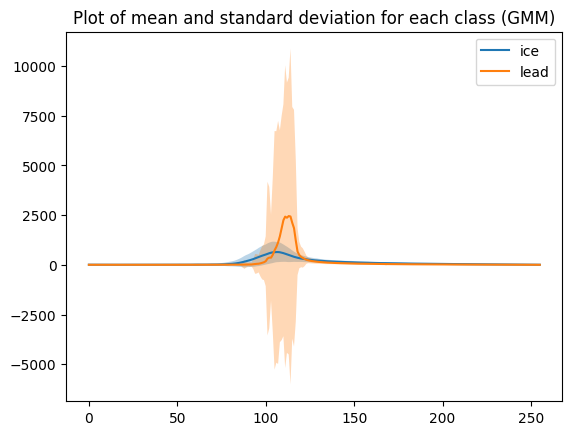

In [51]:
# mean and standard deviation for all echoes
mean_ice = np.mean(waves_cleaned[clusters_gmm==0],axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0], axis=0)

plt.plot(mean_ice, label='ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)


mean_lead = np.mean(waves_cleaned[clusters_gmm==1],axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Plot of mean and standard deviation for each class (GMM)')
plt.legend()

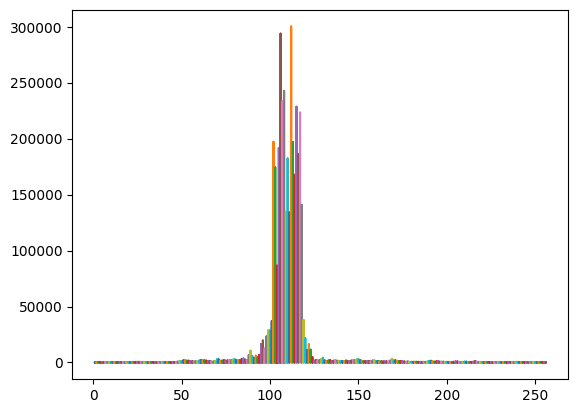

In [15]:
x = np.stack([np.arange(1,waves_cleaned.shape[1]+1)]*waves_cleaned.shape[0])
plt.plot(x,waves_cleaned)  # plot of all the echos
plt.show()

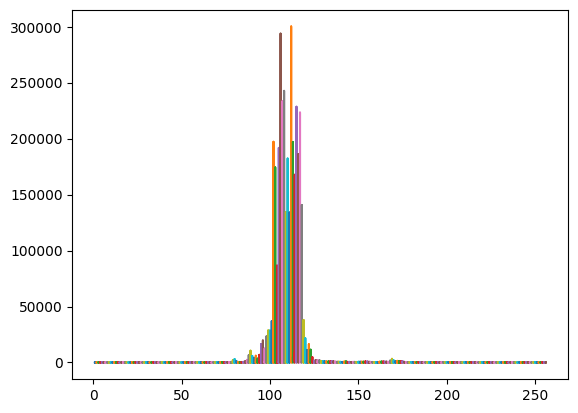

In [16]:
# plot echos for the lead cluster
x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==1].shape[1]+1)]*waves_cleaned[clusters_gmm==1].shape[0])
plt.plot(x,waves_cleaned[clusters_gmm==1])  # plot of all the echos
plt.show()

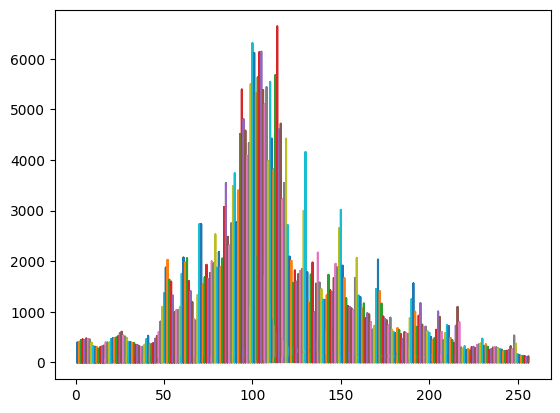

In [17]:
# plot echos for the sea ice cluster
x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==0].shape[1]+1)]*waves_cleaned[clusters_gmm==0].shape[0])
plt.plot(x,waves_cleaned[clusters_gmm==0])  # plot of all the echos
plt.show()

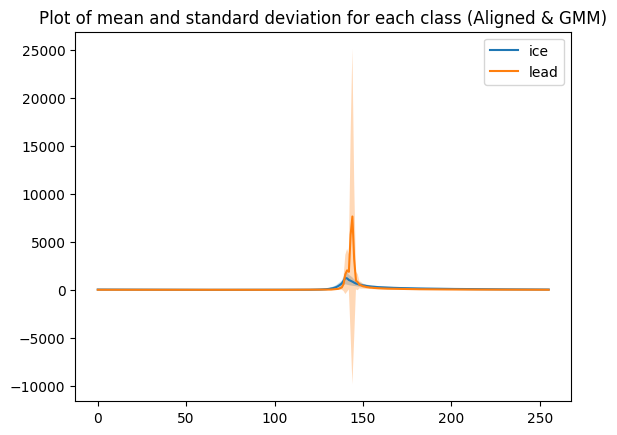

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Align all waveforms
reference_wave = waves_cleaned[0]
aligned_waves_all = []

for wave in waves_cleaned:
    correlation = correlate(wave, reference_wave, mode='same')
    shift = np.argmax(correlation) - (len(wave) // 2)
    aligned_waves_all.append(np.roll(wave, -shift))

aligned_waves_all = np.array(aligned_waves_all)

# Statistics for Cluster 0 (Sea Ice)
mean_ice = np.mean(aligned_waves_all[clusters_gmm==0], axis=0)
std_ice = np.std(aligned_waves_all[clusters_gmm==0], axis=0)

plt.plot(mean_ice, label='ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)

# Statistics for Cluster 1 (Lead)
mean_lead = np.mean(aligned_waves_all[clusters_gmm==1], axis=0)
std_lead = np.std(aligned_waves_all[clusters_gmm==1], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Plot of mean and standard deviation for each class (Aligned & GMM)')
plt.legend()
plt.show()

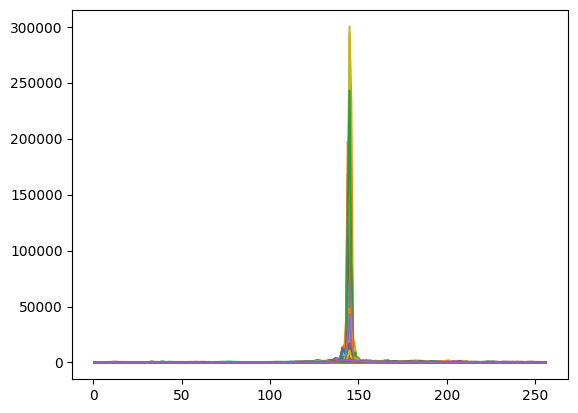

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

reference_wave = waves_cleaned[0]
aligned_waves = []

for wave in waves_cleaned:
    # Calculate cross-correlation and required shift
    correlation = correlate(wave, reference_wave, mode='same')
    shift = np.argmax(correlation) - (len(wave) // 2)

    # Align the waveform using a circular shift
    aligned_waves.append(np.roll(wave, -shift))

aligned_waves = np.array(aligned_waves)

# Create coordinate grid and plot all aligned echoes
x = np.stack([np.arange(1, aligned_waves.shape[1] + 1)] * aligned_waves.shape[0])
plt.plot(x.T, aligned_waves.T)
plt.show()

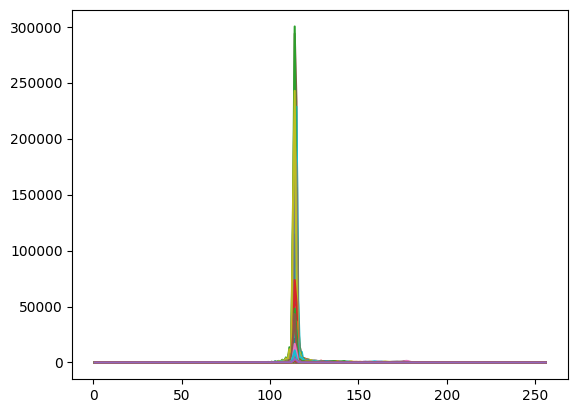

In [20]:
# plot echos for the lead cluster
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

lead_waves = waves_cleaned[clusters_gmm == 1]

reference_wave = lead_waves[0]
aligned_lead = []

for wave in lead_waves:
    correlation = correlate(wave, reference_wave, mode='same')
    shift = np.argmax(correlation) - (len(wave) // 2)
    aligned_lead.append(np.roll(wave, -shift))

aligned_lead = np.array(aligned_lead)

x = np.stack([np.arange(1, aligned_lead.shape[1] + 1)] * aligned_lead.shape[0])
plt.plot(x.T, aligned_lead.T)  # plot of all the echos (aligned)
plt.show()

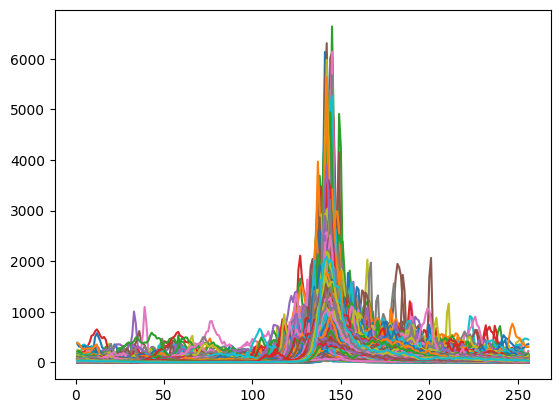

In [21]:
# plot echos for the sea ice cluster
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

ice_waves = waves_cleaned[clusters_gmm == 0]

reference_wave = ice_waves[0]
aligned_ice = []

for wave in ice_waves:
    correlation = correlate(wave, reference_wave, mode='same')
    shift = np.argmax(correlation) - (len(wave) // 2)
    aligned_ice.append(np.roll(wave, -shift))

aligned_ice = np.array(aligned_ice)

x = np.stack([np.arange(1, aligned_ice.shape[1] + 1)] * aligned_ice.shape[0])
plt.plot(x.T, aligned_ice.T)  # plot of all the echos (aligned)
plt.show()

# Compare with ESA data
In the ESA dataset, sea ice = 1 and lead = 2. Therefore, we need to subtract 1 from it so our predicted labels are comparable with the official product labels.

In [32]:
flag_cleaned_modified = flag_cleaned - 1

K-means Confusion Matrix:
[[8872    6]
 [  75 3242]]

K-means Classification Report:
              precision    recall  f1-score   support

 Sea Ice (0)       0.99      1.00      1.00      8878
    Lead (1)       1.00      0.98      0.99      3317

    accuracy                           0.99     12195
   macro avg       0.99      0.99      0.99     12195
weighted avg       0.99      0.99      0.99     12195

Overall Accuracy: 99.34%


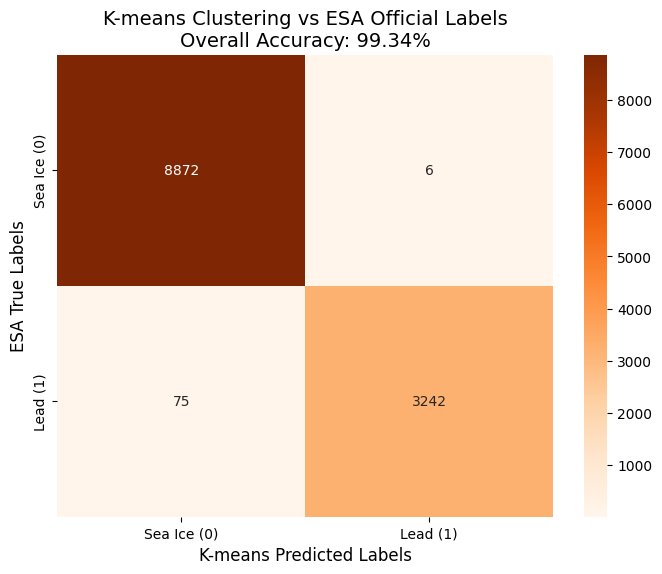

In [64]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define true labels and K-means predictions
true_labels = flag_cleaned_modified
predicted_kmeans = clusters_kmeans

# Auto-correct label inversion: If accuracy is < 50%, flip 0s and 1s
# Unsupervised models may assign labels (0/1) opposite to the ground truth
if accuracy_score(true_labels, predicted_kmeans) < 0.5:
    predicted_kmeans = 1 - predicted_kmeans

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_kmeans)

print("K-means Confusion Matrix:")
print(conf_matrix)

# Generate detailed metrics (Precision, Recall, F1-score)
class_report = classification_report(true_labels, predicted_kmeans,
                                     target_names=['Sea Ice (0)', 'Lead (1)'])

print("\nK-means Classification Report:")
print(class_report)

# Calculate final accuracy for the title
acc = accuracy_score(true_labels, predicted_kmeans)
print(f"Overall Accuracy: {acc:.2%}")

# --- Visualization: Confusion Matrix Heatmap ---
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Sea Ice (0)', 'Lead (1)'],
            yticklabels=['Sea Ice (0)', 'Lead (1)'])

plt.title(f'K-means Clustering vs ESA Official Labels\nOverall Accuracy: {acc:.2%}', fontsize=14)
plt.xlabel('K-means Predicted Labels', fontsize=12)
plt.ylabel('ESA True Labels', fontsize=12)

plt.show()

Confusion Matrix:
 [[8856   22]
 [  24 3293]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8878
         1.0       0.99      0.99      0.99      3317

    accuracy                           1.00     12195
   macro avg       1.00      1.00      1.00     12195
weighted avg       1.00      1.00      1.00     12195



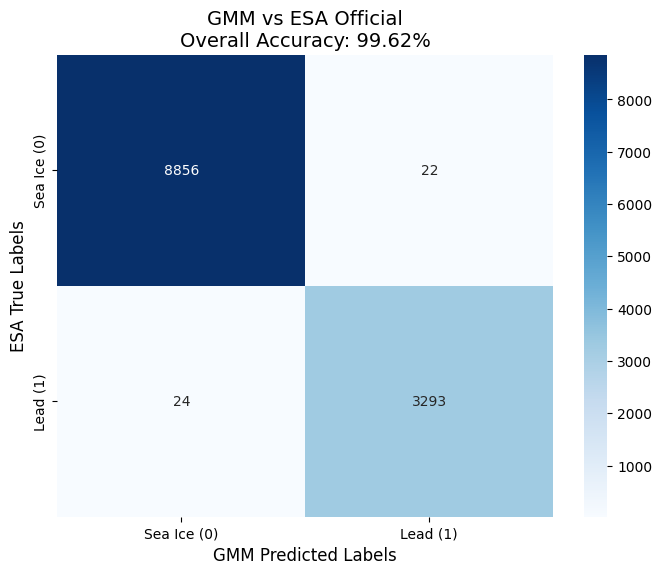

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Define true labels and model predictions
true_labels = flag_cleaned_modified
predicted_gmm = clusters_gmm

# Calculate confusion matrix and accuracy metrics
conf_matrix = confusion_matrix(true_labels, predicted_gmm)
acc = accuracy_score(true_labels, predicted_gmm)
class_report = classification_report(true_labels, predicted_gmm)

# Print numerical evaluation results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Plot the heatmap for visual evaluation
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sea Ice (0)', 'Lead (1)'],
            yticklabels=['Sea Ice (0)', 'Lead (1)'])

# Add descriptive labels and dynamic accuracy title
plt.title(f'GMM vs ESA Official\nOverall Accuracy: {acc:.2%}', fontsize=14)
plt.xlabel('GMM Predicted Labels', fontsize=12)
plt.ylabel('ESA True Labels', fontsize=12)

plt.show()